# Instruction
All python libraries used are listed in the first code cell of each Exercise's Jupyter part.

# Exercise 1

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

1. Implement a two-dimensional k-nearest neighbors classifier and store data in a quad-tree(14 points).Given a new (x, y) point and a value of k (the number of nearest neighbors to examine), it should be able to identify the most common class within those k nearest neighbors (14 points).

Class KNN_2d with method predict() is defined in the below cell to store data in a quad-tree and make classifications of a new input point (x,y).

In [2]:
random.seed(300)

def edist(a,b): #calculate euclidean distance
    return ((a[0]-b[0])**2+(a[1]-b[1])**2)**0.5

def get_data_in_range(data, bbox):
    result = []
    for x, y, condition in data:
        if bbox['xlo'] <= x <= bbox['xhi'] and bbox['ylo'] <= y <= bbox['yhi']:
            result.append([x, y, condition])
    return result

def quantile(series):
    lower_q=np.quantile(series,0.25)
    higher_q=np.quantile(series,0.75)
    return higher_q-lower_q

class QuadTree:

    def __init__(self, data, bounding_box=None, max_leaf_data=3):
        self.desc=len(data)
        self._data = None
        self.children = []

        if bounding_box is None:
            xs, ys, conditions = zip(*data)
            self.xlo = min(xs)
            self.ylo = min(ys)
            self.xhi = max(xs)
            self.yhi = max(ys)
        else:
            self.xlo = bounding_box['xlo']
            self.xhi = bounding_box['xhi']
            self.ylo = bounding_box['ylo']
            self.yhi = bounding_box['yhi']
        if len(data) <= max_leaf_data:
            self._data = data
        else:
            xsplit = (self.xlo + self.xhi) / 2
            ysplit = (self.ylo + self.yhi) / 2
            bbox = [
                {'xlo': self.xlo, 'xhi': xsplit, 'ylo': self.ylo, 'yhi': ysplit},
                {'xlo': self.xlo, 'xhi': xsplit, 'ylo': ysplit, 'yhi': self.yhi},
                {'xlo': xsplit, 'xhi': self.xhi, 'ylo': self.ylo, 'yhi': ysplit},
                {'xlo': xsplit, 'xhi': self.xhi, 'ylo': ysplit, 'yhi': self.yhi}
            ]
            self.children = [
                QuadTree(get_data_in_range(data, my_bbox), my_bbox, max_leaf_data)
                for my_bbox in bbox
            ]

    def __repr__(self):
        return f'<QuadTree xlo={self.xlo} ylo={self.ylo} xhi={self.xhi} yhi={self.yhi} #desc={self.desc}>'

    def contains(self,p):
        x,y=p[:2]
        if self.xlo <= x <= self.xhi and self.ylo <= y <= self.yhi:
            return True
        else: return False

    def contains_minR(self,p,k):
        assert self.contains(p)

        for child in self.children:
            if child.contains(p):
                if child.desc<k:
                    return edist((self.xhi,self.yhi),(self.xlo,self.ylo))
                elif child.desc==k:
                    return edist((child.xhi,child.yhi),(child.xlo,child.ylo))
                else:
                    return child.contains_minR(p,k)

    def _within_distance(self,p,d):
        x,y=p[:2]
        if self.xlo <= x <= self.xhi:
            if self.ylo <= y <= self.yhi:
                return True
            elif  y > self.yhi:
                return  y-self.yhi<d
            else:return  self.ylo-y<d
        elif x>self.xhi:
            if self.ylo <= y <= self.yhi:
                return x-self.xhi<d
            elif  y > self.yhi:
                return  edist((x,y),(self.xhi,self.yhi))<d
            else:return  edist((x,y),(self.xhi,self.ylo))<d
        else:
            if self.ylo <= y <= self.yhi:
                return self.xlo-x<d
            elif  y > self.yhi:
                return  edist((x,y),(self.xlo,self.yhi))<d
            else:return  edist((x,y),(self.xlo,self.ylo))<d

    def leaves_within_distance(self,p,d,leaves_container):
        for child in self.children:
            if child._within_distance(p,d):
                if not child.children:
                    leaves_container+=child._data
                else:
                    child.leaves_within_distance(p,d,leaves_container)

class KNN_2d:
    def __init__(self, X,y, k) -> None:
        data=np.concatenate([X,y.reshape(X.shape[0],1)],axis=1)
        qx0=quantile(X[:,0])
        qx1=quantile(X[:,1])
        # avoid exceeding bounding_box
        self.qTree=QuadTree(data,bounding_box={
            'xlo':min(X[:,0])-qx0,'xhi':max(X[:,0])+qx0,
            'ylo':min(X[:,1])-qx1,'yhi':max(X[:,1])+qx1
        },
        max_leaf_data=min(3,k)     # e.g. k=1
        )
        self.k=k

    def _predict(self,p):
        leaves_container=[]
        R=self.qTree.contains_minR(p,self.k)
        self.qTree.leaves_within_distance(p,R,leaves_container)
        distances=[edist(p,pp)for pp in leaves_container]
        min_i = np.argpartition(distances, self.k)[:self.k]
        classes=[leaves_container[i][2] for i in min_i]
        return max(classes,key=classes.count)

    def predict(self,X):
        return [self._predict(p) for p in X]


2. Normalize the seven quantitative columns to a mean of 0 and standard deviation 1. (3 points)

In [3]:
data = pd.read_excel('Rice_Cammeo_Osmancik.xlsx',sheet_name='Rice')
y=data['Class'].values
X=data.drop('Class', axis=1).values
print(X.shape,y.shape)
for colum in range(len(X[0])):#Normalize X
    value_col=X[:,colum]
    X[:,colum] = (value_col - value_col.mean())/value_col.std()

(3810, 7) (3810,)


3. Plot this PCA on a scatterplot, color-coding by type of rice. (3 points)

In [13]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
data_reduced = pca.fit_transform(X)
pc0 = data_reduced[:, 0]
pc1 = data_reduced[:, 1]
print(pca.explained_variance_ratio_)

[0.65413989 0.21425124]


number of points in class Cammeo (1630,)
number of points in class Osmancik (2180,)


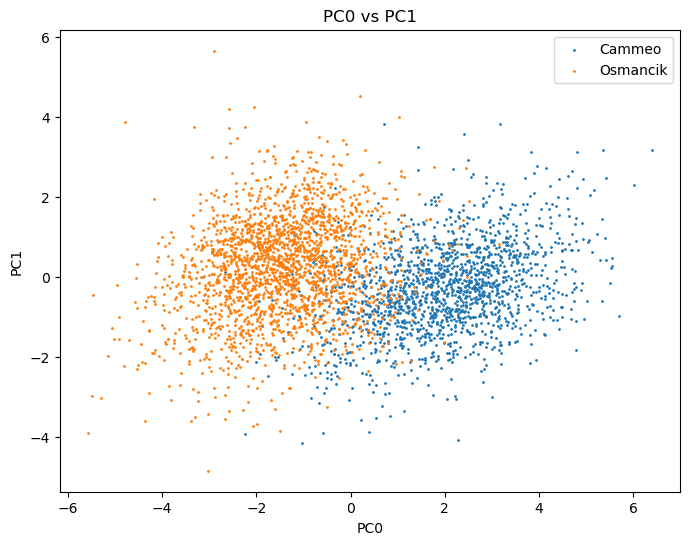

In [30]:
plt.figure(figsize=(8,6))
for c in np.unique(y):
    i = np.where(np.array(y)==c)
    print('number of points in class %s' %c,np.array(pc0)[i].shape)
    plt.scatter(np.array(pc0)[i], np.array(pc1)[i], label=c, s=1)
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title('PC0 vs PC1')
plt.legend()
plt.savefig('PC0-1.png')
plt.show()

4. Comment on what the graph suggests about the effeciveness of using k-nearest neighbors on this 2-dimensional reduction of the data to predict the type of rice. (4 points)

The graph shows that after 2-dimensional PCA reduction, the two classes' majority points are distributed in two separable ellipses. The border of these two clusters is the graph diagonal. Most of the time KNN works well on classifying point types. But if we use KNN to classify a point on the border of these two clusters (e.g., point(0,0)), it will be confused and give a wrong classification as the two classes are almost evenly distributed around the given point.

5. Using a reasonable train-test split with your k-nearest neighbors implementation, give the confusion matrix for predicting the type of rice with k=1. (4 points) Repeat for k=5. (4 points)

confusion_matrix of K=1 
 [[447  71]
 [ 52 573]]


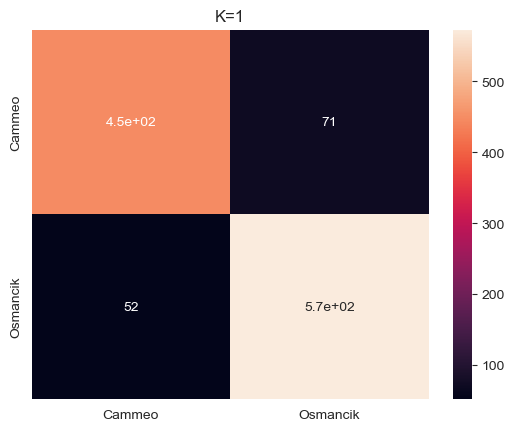

confusion_matrix of K=5 
 [[466  52]
 [ 47 578]]


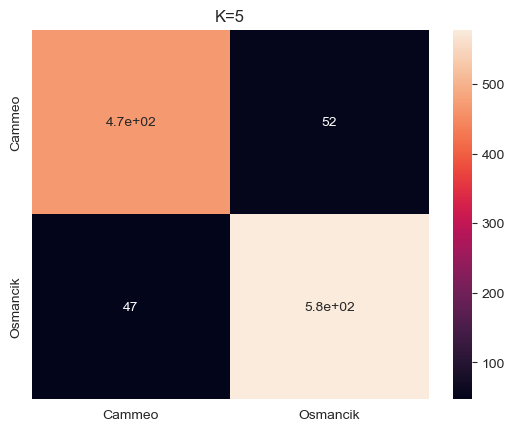

In [4]:
# Read data
y=data['Class'].values
X=data.drop('Class', axis=1).values
# 70% training set, 30% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Data standardization and PCA reduction
STDS = StandardScaler()
STDS.fit(X_train)
X_train = STDS.transform(X_train)
X_test = STDS.transform(X_test)
pca = PCA(n_components=2)
pca.fit(X_train)
X_train=pca.transform(X_train)
X_test=pca.transform(X_test)

# KNN, K=1
clf=KNN_2d(X_train,y_train,1)
pred_k1=clf.predict(X_test)
from sklearn.metrics import confusion_matrix
import seaborn as sns
cfs_mat1=confusion_matrix(y_test,pred_k1)
print('confusion_matrix of K=1 \n',cfs_mat1)
sns.heatmap(pd.DataFrame(cfs_mat1,index=[item for item in set(y_test)],columns=[item for item in set(y_test)]),annot=True)
plt.title('K=1')
plt.show()
# KNN, K=5
clf5=KNN_2d(X_train,y_train,5)
pred_k5=clf5.predict(X_test)
cfs_mat5=confusion_matrix(y_test,pred_k5)
print('confusion_matrix of K=5 \n',cfs_mat5)
sns.heatmap(pd.DataFrame(cfs_mat5,index=[item for item in set(y_test)],columns=[item for item in set(y_test)]),annot=True)
plt.title('K=5')
plt.show()

6. Provide a brief interpretation of what the confusion matrix results mean. (4 points)

The diagonal from top left to bottom right is the number of correct predictions. Row of the matrix is the true label and Column of the matrix is the predicted label.
Take k=1's confusion matrix $\begin{bmatrix} 447 & 71 \\ 52 & 573 \end{bmatrix}$for example.
There are 447 points in the test set are correctly classified to be Osmancik type and 71 points are misclassified to be Cammeo type. Similarly, as for the second row in the matrix, 573 points are correctly classified to be Cammeo type and 52 points are misclassified to be Osmancik type.
The accuracy of KNN(k=1) is $\frac{447+573}{447+71+52+573}=89.23\% $

The accuracy of KNN(k=5) is $\frac{466+578}{466+52+47+578}=91.34\%$

The calculation of Precision, Recall and F1-score is similar to Accuracy calculation.

In [48]:
# Test KNN_2d with sklearn's KNN
clf_=KNeighborsClassifier(1)
clf_.fit(X_train,y_train)
print(np.all(clf_.predict(X_test)==clf.predict(X_test)))
# If True, it means my KNN_2d's performance is the same with sklearn's KNN
clf_5=KNeighborsClassifier(5)
clf_5.fit(X_train,y_train)
print(np.all(clf_5.predict(X_test)==clf5.predict(X_test)))

True
True


In [5]:
print(clf.qTree) # There are 3810 points with 70% in the training set, which is 3810*0.7=2667, corresponding to the desc number

<QuadTree xlo=-8.854877614426485 ylo=-6.44399225253545 xhi=9.793868289701859 yhi=7.227520492611047 #desc=2667>


# Exercise 2

1. What's your data? (4 points)

My data is Heart failure clinical records Data Set downloaded from UCI Machine Learning Repository. The link is https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records#

It contains 299 subjects' clinical data with 13 attributes, such as age, anaemia, high blood pressure, diabetes, sex, smoking and so on. The predictable target label is 'death event', indicating whether the patient died in the follow-up period.

2. What analyses do you want to run and why are they interesting?(4 points)

First I want to do some statistical analyses about the sample distribution, attribute correlations to find whether it is representative and balanced. Then I want to train machine learning models to predict the death rate of a new given input sample. This is the interesting point as users can input any attribute values they want to simulate a virtual patient and get a model's death possibility prediction.

3.  Which ones will be interactive, where the user can provide a parameter? (4 points; there must be at least one).

Users can input several attributes' values such as age(numeric), sex(binary), have diebetes and anaemia or not to give the model's output prediction.

4. What graphs will you make? (4 points)

I'll make several attribute distribution histograms and pie charts to show the dataset distribution, such as samples' age distribution. Also, I'll make a histogram with predicted death possibility on the test set and compare the average death possibility with that from the user's input.

5. Describe how you want your website to work. (4 points)

I'll make a website with one homepage and one interaction page.
On the homepage, I'll display some graphs showing the attribute distribution of our dataset. There is a button to go to the interaction page where users can input several attribute values and get a death possibility back from the trained machine learning model.

6. What do you see as your biggest challenge to completing this, and how do you expect to overcome this challenge? (5 points)

First challenge is the performance of my model. Then the biggest challenge is to reload the trained model to interact with the website's user input and give output predictions to the user interface and present it in a good way. I plan to overcome these challenges by training several kinds of models (SVM, logistic regression, random forest...) and then select one model that performs best (i.e., with the highest accuracy). Then test the website interaction to make sure the code can successfully get users' input, reload the trained model, feed input into the model, and post the predicted output on the website timely.


# Exercise 3

In [1]:
import pandas as pd
import numpy as np
from flask import Flask, render_template, request
import json
import plotly.express as px

1. Perform any necessary data cleaning (e.g. you'll probably want to get rid of the numbers in e.g. "Connecticut(7)" which refer to data source information as well as remove lines that aren't part of the table). Include the cleaned CSV file in your homework submission, and make sure your readme includes a citation of where the original data came from and how you changed the csv file. (5 points)

Data downloaded from https://statecancerprofiles.cancer.gov/incidencerates/index.php is cleaned by the following code.
First, I manually removed irrelevant lines to only keep the table. The table shape is (53,13).
Then I removed the 4 rows with obvious N/A, 'data not available' and '*' cells. The new table shape is (49,13) and the new file is named as 'incd_new.csv' for further cleaning as below.
In the following code cell, I drop all numbers in state names' parentheses and changed a column name from 'Age-Adjusted Incidence Rate([rate note]) - cases per 100,000' to 'Age-Adjusted Incidence Rate' to make it shorter.

In [14]:
raw_data=pd.read_csv('incd_new.csv')
print(raw_data.shape)
# drop out all numbers in () parentheses
raw_name=raw_data['State'].str.split('(').tolist()
new_name=np.array(raw_name)
raw_data['State']=new_name[:,0]
print(raw_data['State'].head())
# Rename the column to make it shorter
raw_data=raw_data.rename(columns={'Age-Adjusted Incidence Rate([rate note]) - cases per 100,000':'Age-Adjusted Incidence Rate'})
raw_data.to_csv('incd_clean.csv',index=None)

(49, 13)
0         Kentucky
1             Iowa
2       New Jersey
3    West Virginia
4         New York
Name: State, dtype: object


2. Using Flask, implement a server that provides three routes (5 points each)@app.route("/"), @app.route("/state/<string:name>"), @app.route("/info", methods=["GET"])

This is the homepage(route'/') screenshot:
![jupyter](./homepageflask.PNG)

I stored several common valid names of states in state_name_map.json. For example, Connecticut can be input in other ways such as CT, Conn., ct, connecticut. Other lines in the json file look like: "District of Columbia": ["DC", "D.C.", "dc", "washington, d.c.", "district of columbia"],"Florida": ["FL", "Fla.", "fl", "florida"]. Capitalization and period matter. All other unusual names not in the json file are considered as invalid names.

This is the /info page screenshot with input 'CT':

![jupyter](./infopage.PNG)


This is the /info page screenshot with an invalid input 'ConNECTICut':

![jupyter](./invalidpage.PNG)

3.  Take this exercise one step beyond that which is described above in a way that you think is appropriate, and discuss your extension in your readme. (5 points).

Extension:
I add a route @app.route('/map') to show a map about age-adjusted incidence rate by state using plotly.express
The map looks like:

![jupyter](./plotlymap.PNG)

In [2]:
state_data=pd.read_csv('incd_clean.csv')
state_data['Age-Adjusted Incidence Rate'].astype(float)

# Read a json file containing states' different names
with open('state_name_map.json', 'r') as f:
    state_map_json = f.read()
state_name_map = json.loads(state_map_json)

app = Flask(__name__)

@app.route("/")
def index():
    return render_template("index.html")

@app.route("/state/<string:name>")
def state(name):
    try:
        rate=state_data.loc[state_data['State'] == name,'Age-Adjusted Incidence Rate'].values[0]
        ci_rank=state_data.loc[state_data['State'] == name,'CI*Rank([rank note])'].values[0]
        count=state_data.loc[state_data['State'] == name,'Average Annual Count'].values[0]
    except:pass
    if rate:
        response = {
            'state': name,
            'age-adjusted rate': rate,
            'CI*rank':ci_rank,
            'annual count':count
        }
        return json.dumps(response)
    else:
        return 'Invalid state name', 404

@app.route("/info", methods=["GET"])
def info():
    state = request.args.get('state')
    # If the input state name is valid (as defined in the aforementioned json file) and in our dataset
    for name, info in state_name_map.items():
        if state in info or state==name:
            return render_template('state_info.html', state=name,
            rate=state_data.loc[state_data['State'] == name,'Age-Adjusted Incidence Rate'].values[0],
            ci_rank=state_data.loc[state_data['State'] == name,'CI*Rank([rank note])'].values[0],
            count=state_data.loc[state_data['State'] == name,'Average Annual Count'].values[0]
            )
    # Else, the input is an invalid name
    return render_template('state_info.html')


@app.route('/map')
def show_map():
    # Read state name and incidence rate data
    state_data['code']=None
    for i in state_data['State'][1:]:
        state_data.loc[state_data['State'] == i,'code']=state_name_map[i][0]
    fig = px.choropleth(state_data,
                    locations='code',
                    locationmode='USA-states',
                    color='Age-Adjusted Incidence Rate',
                    title='Age-Adjusted Incidence Rate by State',
                    color_continuous_scale=px.colors.sequential.Plasma,
                    scope='usa',
                    )
    figure_json = fig.to_json()
    return render_template('map.html', figure_json=figure_json)

if __name__ == "__main__":
    app.run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [09/Dec/2022 20:48:15] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2022 20:51:48] "GET /info?state=CT HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2022 20:53:13] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2022 20:53:15] "GET /info?state=ConNECTICut HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2022 20:54:28] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2022 20:54:29] "GET /map HTTP/1.1" 200 -


# Appendix
## Here are the templates' file.html

1. index.html

![jupyter](./indexhtml.PNG)

2. state_info.html

![jupyter](./stateinfohtml.PNG)

3. map.html

![jupyter](./maphtml.PNG)